In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [28]:
fec = pd.read_csv(r'C:\Users\matte\OneDrive\Desktop\GitHub\data\py_4_dataana\fec\P00000001-ALL.csv',
                  low_memory=False)

In [29]:
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

In [30]:
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,368633403,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,719016467,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166


In [31]:
fec['cand_nm'].unique()

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [32]:
parties = {"Bachmann, Michelle": "Republican",
           "Cain, Herman": "Republican",
           "Gingrich, Newt": "Republican",
           "Huntsman, Jon": "Republican",
           "Johnson, Gary Earl": "Republican",
           "McCotter, Thaddeus G": "Republican",
           "Obama, Barack": "Democrat",
           "Paul, Ron": "Republican",
           "Pawlenty, Timothy": "Republican",
           "Perry, Rick": "Republican",
           "Roemer, Charles E. 'Buddy' III": "Republican",
           "Romney, Mitt": "Republican",
           "Santorum, Rick": "Republican"}

fec['cand_nm'][:10].map(parties)

0    Republican
1    Republican
2    Republican
3    Republican
4    Republican
5    Republican
6    Republican
7    Republican
8    Republican
9    Republican
Name: cand_nm, dtype: object

In [33]:
fec['party'] = fec['cand_nm'].map(parties)

In [34]:
fec['party'].value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

In [35]:
(fec['contb_receipt_amt'] > 0).value_counts()

contb_receipt_amt
True     991475
False     10256
Name: count, dtype: int64

In [36]:
fec = fec[fec['contb_receipt_amt'] > 0]

In [37]:
fec_mrbo = fec[fec["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"])]

In [39]:
fec['contbr_occupation'].value_counts()[:10]

contbr_occupation
RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: count, dtype: int64

In [40]:
occ_mapping = {
   "INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
   "INFORMATION REQUESTED" : "NOT PROVIDED",
   "INFORMATION REQUESTED (BEST EFFORTS)" : "NOT PROVIDED",
   "C.E.O.": "CEO"
}

def get_occ(x):
    # If no mapping provided, return x
    return occ_mapping.get(x, x)

fec["contbr_occupation"] = fec["contbr_occupation"].map(get_occ)

In [41]:
emp_mapping = {
   "INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
   "INFORMATION REQUESTED" : "NOT PROVIDED",
   "SELF" : "SELF-EMPLOYED",
   "SELF EMPLOYED" : "SELF-EMPLOYED",
}

def get_emp(x):
    # If no mapping provided, return x
    return emp_mapping.get(x, x)

fec["contbr_employer"] = fec["contbr_employer"].map(get_emp)

In [43]:
table = fec.pivot_table('contb_receipt_amt', index='contbr_occupation',
                columns='party', aggfunc='sum')
table = table[table.sum(axis='columns') > 2_000_000]
table

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
CEO,2074974.79,4211040.52
CONSULTANT,2459912.71,2544725.45
ENGINEER,951525.55,1818373.70
EXECUTIVE,1355161.05,4138850.09
HOMEMAKER,4248875.80,13634275.78
INVESTOR,884133.00,2431768.92
LAWYER,3160478.87,391224.32
MANAGER,762883.22,1444532.37


<Axes: ylabel='contbr_occupation'>

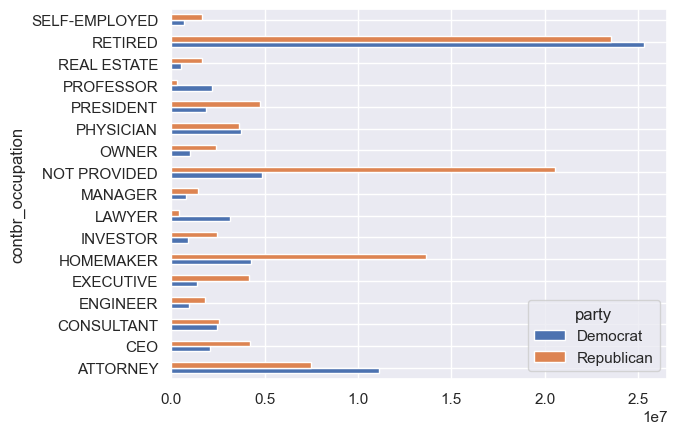

In [45]:
table.plot.barh()

In [38]:
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,368633403,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073,Republican
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073,Republican
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,719016467,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican


In [53]:
top_c = fec.groupby('contbr_nm')['contb_receipt_amt'].sum().to_frame()

In [54]:
top_c.head(
    
)

,contb_receipt_amt
contbr_nm,
"COMMUNITY OF THE AUBURN, UNITED AUBURN INDIAN RANCHERIA",1000.0
"---, DANN",201.2
"-------------------, DANN ----------",450.0
"--------------------, DANN ----------",1000.0
"A AYDELOTT, JUDITH",500.0


In [55]:
top_c.sort_values('contb_receipt_amt', ascending=False)[:10]

,contb_receipt_amt
contbr_nm,
OBAMA VICTORY FUND 2012 - UNITEMIZED,8639522.84
"MURPHY, CYNTHIA C.",35800.00
"DAVIS, STEPHEN JAMES",30800.00
SOUTH CAROLINA REPUBLICAN PARTY,25000.00
LIBERTY PAC,25000.00
"HILLMAN, TATNALL",22500.00
"NICHOLSON, JAMES B. MR.",22500.00
"SMITH, DAVID",20102.32
"CROW, KATHERINE RAYMOND MRS.",20000.00
